In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import pathlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image
%matplotlib inline

In [2]:
MODEL_NAME = 'face_detection_graph'
PATH_TO_CKPT = './frozen_inference_graph.pb'

In [41]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('../data/images/test')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))[60:70]
TEST_IMAGE_PATHS

[WindowsPath('../data/images/test/a77678b3-836c-4661-8435-cbfe7f0bd6fe.jpg'),
 WindowsPath('../data/images/test/ab3584f5-b16e-4eaf-ab05-a282b7513f08.jpg'),
 WindowsPath('../data/images/test/ad369a91-d82c-4ca0-b669-f580aabde389.jpg'),
 WindowsPath('../data/images/test/af665629-b71b-461f-bfe8-0057a682399e.jpg'),
 WindowsPath('../data/images/test/b012caf1-569f-42c7-9abd-ff43012c7e97.jpg'),
 WindowsPath('../data/images/test/b8b488e6-4912-418f-afb9-4b76c193c945.jpg'),
 WindowsPath('../data/images/test/bcb52ae4-99d7-43cd-a7c9-5d0bac21b711.jpg'),
 WindowsPath('../data/images/test/c2517cd6-cba1-46f3-9c80-711e79a20d8e.jpg'),
 WindowsPath('../data/images/test/c62acd89-a77e-402c-aef7-59e445710580.jpg'),
 WindowsPath('../data/images/test/c798ab5d-88f2-416a-a380-73c4bf5181d3.jpg')]

In [4]:
# load frozen graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(graph_def, name='')

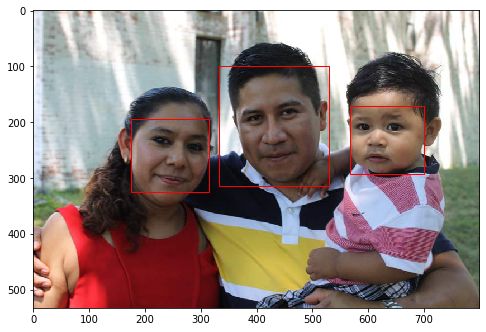

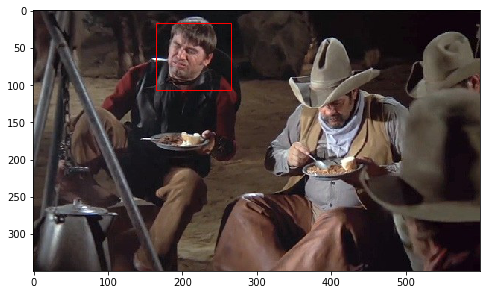

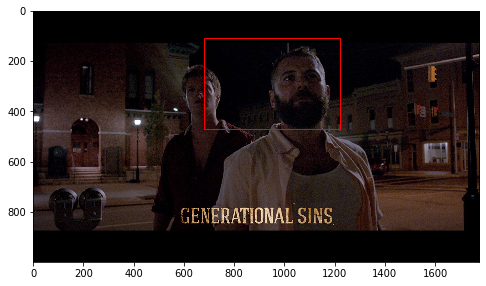

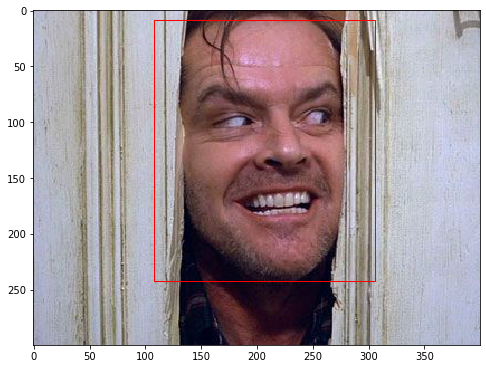

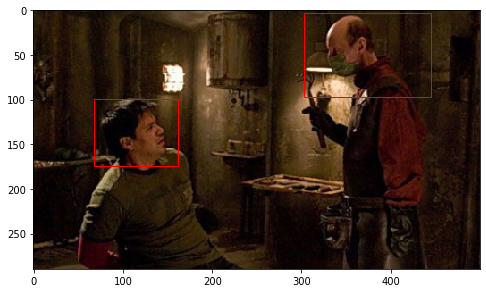

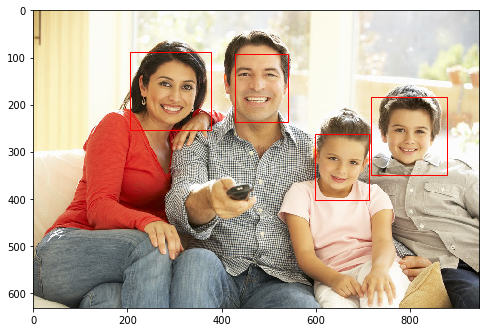

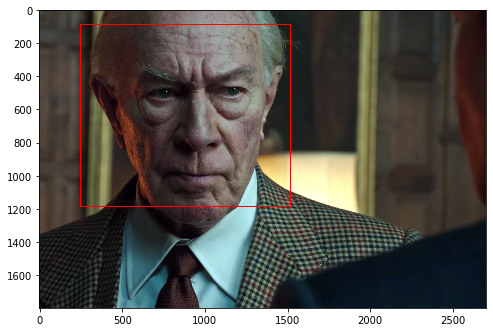

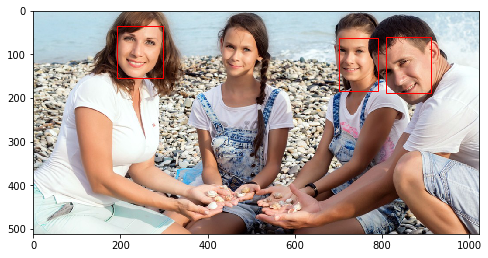

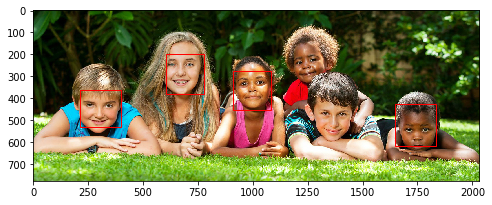

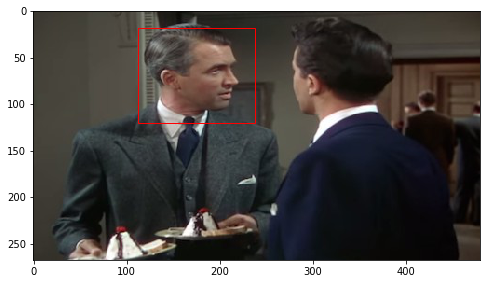

In [63]:
def plot_image_with_boxes(image, boxes, scores):
    width, height = image.size
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()
    for i in range(boxes.shape[0]):
        ymin, xmin, ymax, xmax = boxes[i]
        xmin *= width
        xmax *= width
        ymin *= height
        ymax *= height
    
        rect = patches.Rectangle(
            (xmin, ymin), 
            xmax-xmin, 
            ymax-ymin,
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
    plt.show()
        
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for i, img_path in enumerate(TEST_IMAGE_PATHS):
            image = Image.open(img_path)
            image_np = np.asarray(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            boxes, scores, classes, num_detections = (sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor:image_np_expanded}
            ))
            boxes = boxes.squeeze()
            scores = scores.squeeze()
            
            max_outputs = 6
            iou_threshold = 0.3
            score_threshold = 0.5
            selected_indices = sess.run(
                tf.image.non_max_suppression(
                    boxes, 
                    scores, 
                    max_outputs, 
                    iou_threshold, 
                    score_threshold
                )
            )
            
            selected_boxes = sess.run(tf.gather(boxes, selected_indices))
            plot_image_with_boxes(
                image,
                selected_boxes,
                scores[selected_indices],
            )

In [80]:
import cv2

cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_np_expanded = np.expand_dims(frame, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            boxes, scores, classes, num_detections = (sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor:image_np_expanded}
            ))
            boxes = boxes.squeeze()
            scores = scores.squeeze()
            max_outputs = 6
            iou_threshold = 0.5
            score_threshold = 0.5
            selected_indices = sess.run(
                tf.image.non_max_suppression(
                    boxes, 
                    scores, 
                    max_outputs, 
                    iou_threshold, 
                    score_threshold
                )
            )
            
            selected_boxes = sess.run(tf.gather(boxes, selected_indices))
            selected_scores = sess.run(tf.gather(scores, selected_indices))
            w, h = frame.shape[1], frame.shape[0]
            for i in range(len(selected_boxes)):
                b = selected_boxes[i]
                ymin, xmin, ymax, xmax = b
                xmin *= w
                xmax *= w
                ymin *= h
                ymax *= h
                frame = cv2.rectangle(frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
    cv2.imshow('You', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()